# Reinforcement Learning Project: Control in a Continuous Action Space with DDPG

In this project, we will explore the Deep Deterministic Policy Gradient (DDPG) algorithm, which is designed to handle continuous action spaces in Reinforcement Learning. We will use the Pendulum-v1 environment implemented in OpenAI Gym to implement the DDPG algorithm from scratch to solve the classical control problem of stabilizing an inverted pendulum. Throughout the development, we will incrementally build the components of DDPG and analyze their importance for correct and effective learning. This Jupyter notebook contains our implementation and report for this project. 

The instructions are available in `Miniproject_DDPG.pdf` file.

In [5]:
import numpy as np
import gym
from helpers import NormalizedEnv
from helpers import RandomAgent

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import deque


In [6]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device {device} is available")

Device cuda is available


## Heuristic policy

In [7]:
# Create environement instance, an instance of the Pendulum-v1 environment wrapped in a NormalizedEnv class
# to normalize the action space between -1 and 1
env = gym.make('Pendulum-v1', render_mode='rgb_array')
env = NormalizedEnv(env)

# Create a RandomAgent
random_agent = RandomAgent(env)

def run_agent(agent: 'Agent', env: NormalizedEnv, num_episodes: int) -> float:
    """Run the agent for `num_episodes` episodes and return the average reward"""
    rewards = [] # Will contain the reward of each step
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        while True:
            # Simulation step
            action = agent.compute_action(state)
            state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            if trunc:
                break
        rewards.append(episode_reward)
    return np.mean(rewards)

average_reward = run_agent(random_agent, env, 10)
print('Average reward over 10 episodes: {}'.format(average_reward))

Average reward over 10 episodes: -1230.099044303182


In [8]:
class HeuristicPendulumAgent:
    def __init__(self, env: NormalizedEnv, torque_intensity: float=1.0) -> None:
        """Heuristic agent for the Pendulum-v1 environment."""
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.torque_intensity = torque_intensity
        
    def compute_action(self, state):
        """Compute the action to apply to the environment.

        When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity.
        When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.
        """
        action = np.where(state[..., 0] < 0, # If the pendulum is in the lower half of the circle
                        np.sign(state[..., 2]) * self.torque_intensity, 
                        -np.sign(state[..., 2]) * self.torque_intensity)
        return action


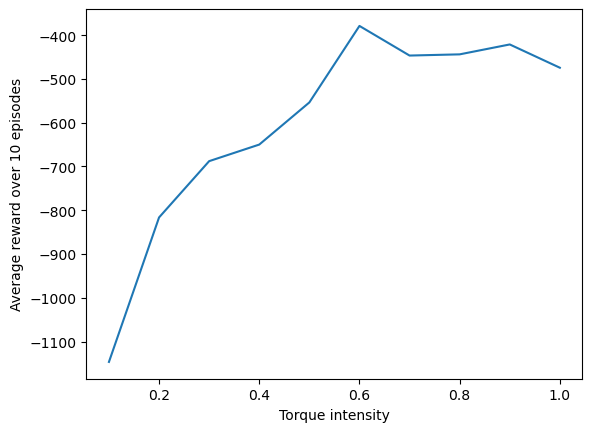

Best torque intensity: 0.6
Best reward over 10 episodes: -378.75888685361457


In [9]:
# Find best torque intensity
torque_intensities = np.linspace(0.1, 1, 10)
rewards = []
for torque_intensity in torque_intensities:
    heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensity)
    rewards.append(run_agent(heuristic_agent, env, 10))

plt.plot(torque_intensities, rewards)
plt.xlabel('Torque intensity')
plt.ylabel('Average reward over 10 episodes')
plt.show()

# Create a HeuristicPendulumAgent with the best torque intensity
heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensities[np.argmax(rewards)])
# Print best reward over 10 episodes and associated torque intensity
print('Best torque intensity: {}'.format(torque_intensities[np.argmax(rewards)]))
print('Best reward over 10 episodes: {}'.format(np.max(rewards)))


In [10]:
# Animation of the Heuristic Agent using PIL
state, _ = env.reset()
frames = []
while True:
    action = heuristic_agent.compute_action(state)
    state, reward, _, trunc, _ = env.step(action)
    frames.append(env.render())
    if trunc:
        break

frames = np.array(frames)
frames = [Image.fromarray(frame) for frame in frames]
frames[0].save("heuristic_agent.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)


## Q function of the heuristic policy

In [36]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        """Buffer to store transitions.

        A transition is a tuple (state, action, reward, next_state, trunc) where:
            state (np.ndarray[(3,), np.float32]): State of the environment.
            action (np.ndarray[(1,), np.float32]): Action applied to the environment.
            reward (np.ndarray[(1,), np.float32]): Reward obtained after applying the action.
            next_state (np.ndarray[(3,), np.float32]): State of the environment after applying the action.
            trunc (np.ndarray[(1,), np.bool]): Boolean indicating if the episode is truncated.
        
        The buffer is implemented as 5 (one for each element of a transition) cyclic numpy arrays of shape 
        (capacity, *) where * is the shape of the corresponding element of a transition.
        When the buffer is full, the oldest transitions are dropped.
        
        Args:
            capacity (int): Capacity of the buffer.
            transition_type (np.dtype): Type of the transitions to store.
        """
        # Maximum number of transitions to store in the buffer. 
        # When the buffer overflows the old memories are dropped.
        self.capacity = capacity 
        # Numpy array of transitions
        self.states = np.empty((capacity, 3), np.float32)
        self.actions = np.empty((capacity, 1), np.float32)
        self.rewards = np.empty((capacity, 1), np.float32)
        self.next_states = np.empty((capacity, 3), np.float32)
        self.truncs = np.empty((capacity, 1), bool)
        # Index of the next transition to be stored
        self.index = 0
        # Current size of the buffer
        self.size = 0

    def append(self, transition):
        """Add a transition to the buffer.
        
        See constructor docstring for explanation of a transition.
        """
        # Add transition to current index
        self.states[self.index] = transition[0]
        self.actions[self.index] = transition[1]
        self.rewards[self.index] = transition[2]
        self.next_states[self.index] = transition[3]
        self.truncs[self.index] = transition[4]
        # Update index
        self.index = (self.index + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        """Sample a batch of size `batch_size` of transitions from the buffers."""
        indexes = np.random.choice(self.size, batch_size, replace=False)
        return self[indexes]

    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, slice):
        return (self.states[slice], 
                self.actions[slice], 
                self.rewards[slice], 
                self.next_states[slice], 
                self.truncs[slice])


In [20]:
class QNetwork(nn.Module):
    def __init__(self, state_size: int=3, action_size: int=1):
        """QNetwork. Maps (state, action) pairs to Q-values."""
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state, action):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor
            action (torch.Tensor): Action tensor

        Returns:
            q_value (torch.Tensor): Q-value tensor
        """
        
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def TD_learning_update(q_network, agent, optimizer, transitions, gamma):
    """Perform a 1-step TD-learning update for a batch of transitions.

    Args:
        q_network (QNetwork): QNetwork instance
        agent (Agent): Agent (i.e. Policy) instance
        optimizer (torch.optim): Optimizer instance
        transitions (List[Transition]): Batch of transitions
        gamma (float): Discount factor

    Returns:
        loss (float): Loss value
    """
    states = transitions[0]
    actions = transitions[1]
    rewards = transitions[2]
    next_states = transitions[3]
    truncs = transitions[4]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states)
    actions_t = torch.from_numpy(actions)
    rewards_t = torch.from_numpy(rewards)
    next_states_t = torch.from_numpy(next_states)
    truncs_t = torch.from_numpy(truncs)


    with torch.no_grad():
        next_actions = agent.compute_action(next_states)
        next_actions_t = torch.as_tensor(next_actions)[:, None].float()
        # Naive next Q-values (i.e. without taking truncation into account)
        naive_next_qs = q_network(next_states_t, next_actions_t)
        # Actual next Q-values (i.e. taking truncation into account)
        next_qs = torch.where(truncs_t, 
                              torch.zeros_like(rewards_t), 
                              naive_next_qs)
        gamma = torch.tensor(gamma, dtype=torch.float32)
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


Episode 0
Episode 10
Episode 20
Episode 30
Episode 40
Episode 50
Episode 60
Episode 70
Episode 80
Episode 90
Episode 100
Episode 110
Episode 120
Episode 130
Episode 140
Episode 150
Episode 160
Episode 170
Episode 180
Episode 190
Episode 200
Episode 210
Episode 220
Episode 230
Episode 240
Episode 250
Episode 260
Episode 270
Episode 280
Episode 290
Episode 300
Episode 310
Episode 320
Episode 330
Episode 340
Episode 350
Episode 360
Episode 370
Episode 380
Episode 390
Episode 400
Episode 410
Episode 420
Episode 430
Episode 440
Episode 450
Episode 460
Episode 470
Episode 480
Episode 490
Episode 500
Episode 510
Episode 520
Episode 530
Episode 540
Episode 550
Episode 560
Episode 570
Episode 580
Episode 590
Episode 600
Episode 610
Episode 620
Episode 630
Episode 640
Episode 650
Episode 660
Episode 670
Episode 680
Episode 690
Episode 700
Episode 710
Episode 720
Episode 730
Episode 740
Episode 750
Episode 760
Episode 770
Episode 780
Episode 790
Episode 800
Episode 810
Episode 820
Episode 830
Epi

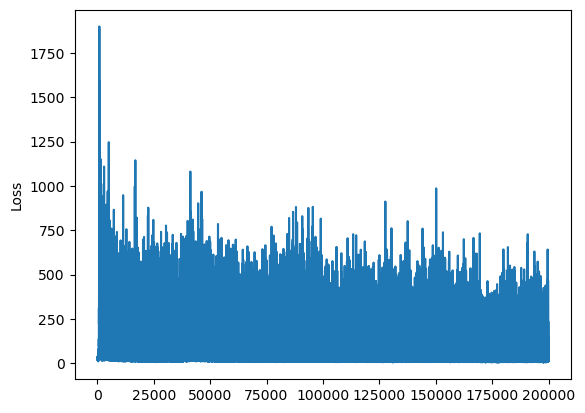

In [37]:
capacity = 10000 # Capacity of the replay buffer
replay_buffer = ReplayBuffer(capacity=capacity)
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0])
optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
gamma = 0.99

"""
Check dimensionality before and after buffer
Check also just at the beginning of the forward method, at the error computation
"""

# Training loop for the Q-learning

n_episodes = 1000 # Number of episodes
# Number of steps per episode, see documentation of the Pendulum-v1 environment
n_steps = 200
batch_size = 128 # Batch size for the TD-learning update
# Container for the loss of each step except the first (batch_size-1) steps
# since we wait for the buffer to be filled at size batch_size at least
losses = np.empty((n_episodes * n_steps - batch_size + 1, 1))
i = 0
for episode in range(n_episodes):
    state, _ = env.reset()
    while True:
        # Simulation step
        action = heuristic_agent.compute_action(state)
        next_state, reward, _, trunc, _ = env.step(action)
        replay_buffer.append((state, action, reward, next_state, trunc))
        # Training step
        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            loss = TD_learning_update(q_network, heuristic_agent, optimizer, transitions, gamma)
            losses[i] = loss.item()
            i += 1

        if trunc:
            break
        state = next_state
    if episode % 10 == 0 and len(losses) > 0:
        print(f'Episode {episode}')

plt.plot(losses)
plt.ylabel('Loss')
plt.show()


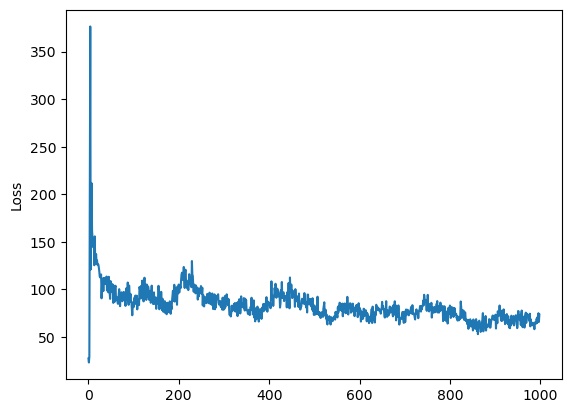

In [38]:
#plot mean losses over windows of size 2000
#plt.plot([np.mean(losses[i:i+2000]) for i in range(len(losses))])
# Plot mean losses over batch of 2000
size = n_steps
plt.plot([np.mean(losses[i:i+size]) for i in range(0, len(losses)-size, size)])

plt.ylabel('Loss')
plt.show()

In [15]:
backup_losses = losses